In [7]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt
from icecream import ic

In [8]:
# Data import and cleaning
file_time_a = '../Time Development/Data/time_a.csv'
file_time_b_decay = '../Time Development/Data/time_b_decay.csv'
file_time_b_normal = '../Time Development/Data/time_b_normal.csv'
file_time_b_growth = '../Time Development/Data/time_b_growth.csv'

time_a_df = pd.read_csv(file_time_a)
time_b_decay_df = pd.read_csv(file_time_b_decay)
time_b_normal_df = pd.read_csv(file_time_b_normal)
time_b_growth_df = pd.read_csv(file_time_b_growth)

for df in [time_a_df, time_b_decay_df, time_b_normal_df, time_b_growth_df]:
    if "Unnamed: 0" in df.columns:
        df.drop(columns=["Unnamed: 0"], inplace=True)
    df["Date"] = pd.to_datetime(df["Date"])

In [9]:
# Only care about engagement not CTR
features = ["Engagement"]

In [10]:
# CUSUM
def manual_cusum(x, threshold=5, drift=0.01):
    x = np.array(x)
    mean = np.mean(x)
    pos_cusum = np.zeros(len(x))
    neg_cusum = np.zeros(len(x))
    change_indices = []

    for i in range(1, len(x)):
        s_pos = max(0, pos_cusum[i-1] + x[i] - mean - drift)
        s_neg = max(0, neg_cusum[i-1] - x[i] + mean - drift)
        pos_cusum[i] = s_pos
        neg_cusum[i] = s_neg
        if s_pos > threshold or s_neg > threshold:
            change_indices.append(i)
            pos_cusum[i] = 0
            neg_cusum[i] = 0

    return change_indices

In [11]:
# --- CUSUM Detection + Plotting + Evaluation ---
def detect_cusum_changes(time_a_df, time_b_df, scenario_name, feature, threshold=5):
    combined_df = pd.concat([time_a_df, time_b_df], ignore_index=True).sort_values("Date")
    daily_avg = combined_df.groupby("Date")[feature].mean()
    launch_date = time_a_df["Date"].iloc[-1]

    change_idx = manual_cusum(daily_avg.values, threshold=threshold)
    change_dates = [daily_avg.index[i] for i in change_idx]

    # --- Evaluation ---
    cps_before = [d for d in change_dates if d < launch_date]
    cps_after = [d for d in change_dates if d > launch_date]
    detected_before = len(cps_before) > 0
    detected_after = len(cps_after) > 0

    if "Normal" in scenario_name:
        TP = 0
        FP = len(cps_before) + len(cps_after)
        FN = 0
        TN = int(not detected_before and not detected_after)
    else:
        TP = int(detected_after)
        FP = len(cps_before)
        FN = int(not detected_after)
        TN = 0

    if TP + FP == 0 and TP + FN == 0:
        precision = recall = f1 = "N/A"
    else:
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # --- Plot ---
    daily_avg_a = daily_avg[daily_avg.index <= launch_date]
    daily_avg_b = daily_avg[daily_avg.index > launch_date]

    plt.figure(figsize=(10, 5))
    plt.plot(daily_avg_a.index, daily_avg_a.values, label="Time A (Daily Avg)", color="cadetblue")
    plt.plot(daily_avg_b.index, daily_avg_b.values, label="Time B (Daily Avg)", color="mediumslateblue")

    first_detected = None
    for cp in change_dates:
        color = "green" if (cp > launch_date and first_detected is None) else "orange"
        if color == "green":
            first_detected = cp
        plt.axvline(x=cp, color=color, linestyle="--", alpha=0.9, label="Change Point")

    plt.axvline(x=launch_date, color="red", linestyle="--", label="Product Launch")


    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title(f"{feature} - CUSUM Change Detection ({scenario_name})")
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"Charts/cusum_{scenario_name.replace(' ', '_')}_{feature}.png")
    plt.show()

    # --- Summary row ---
    return {
        "Time B Type": scenario_name.split(" ")[0],
        "Scenario": scenario_name,
        "Feature": feature,
        "Launch Date": launch_date.date(),
        "Change Points": [d.date() for d in change_dates],
        "Days After Launch": [(d - launch_date).days for d in change_dates],
        "Count": len(change_dates),
        "TP": TP, "FP": FP, "FN": FN, "TN": TN,
        "Precision": precision if isinstance(precision, str) else round(precision, 2),
        "Recall": recall if isinstance(recall, str) else round(recall, 2),
        "F1 Score": f1 if isinstance(f1, str) else round(f1, 2)
    }

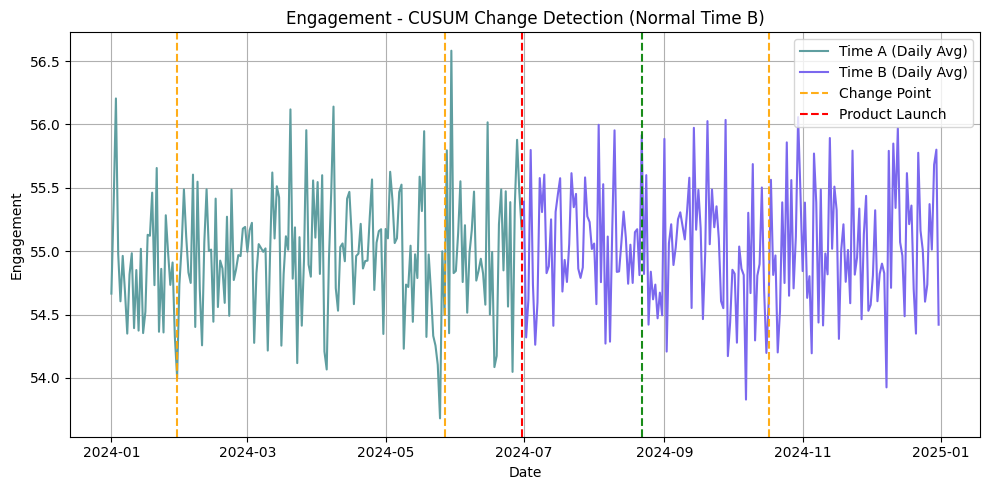

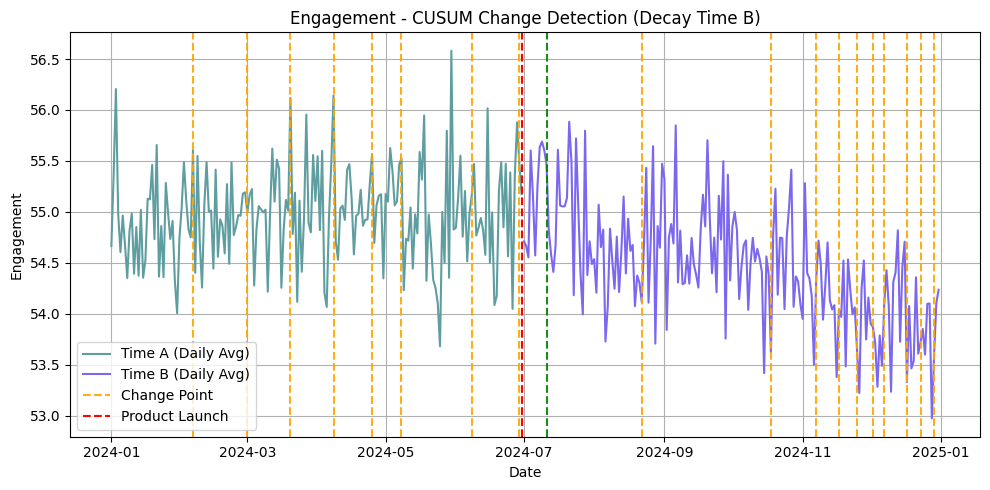

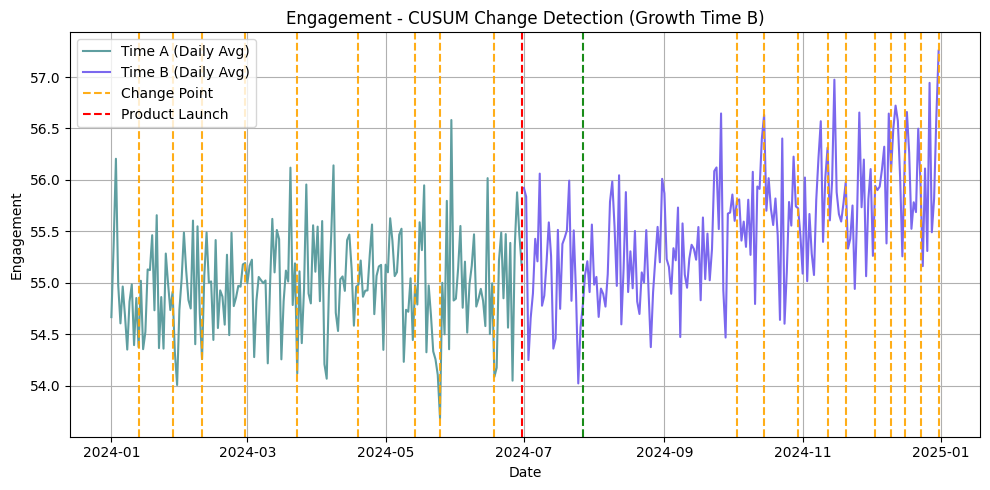

CUSUM Summary
  Time B Type       Scenario     Feature Launch Date  \
0      Normal  Normal Time B  Engagement  2024-06-30   
1       Decay   Decay Time B  Engagement  2024-06-30   
2      Growth  Growth Time B  Engagement  2024-06-30   

                                       Change Points  \
0   [2024-01-30, 2024-05-27, 2024-08-22, 2024-10-17]   
1  [2024-02-06, 2024-03-01, 2024-03-20, 2024-04-0...   
2  [2024-01-13, 2024-01-28, 2024-02-10, 2024-02-2...   

                                   Days After Launch  Count  TP  FP  FN  TN  \
0                               [-152, -34, 53, 109]      4   0   4   0   0   
1  [-145, -121, -102, -83, -66, -53, -22, -1, 11,...     19   1   8   0   0   
2  [-169, -154, -141, -122, -99, -72, -47, -36, -...     20   1   9   0   0   

   Precision  Recall  F1 Score  
0       0.00     0.0      0.00  
1       0.11     1.0      0.20  
2       0.10     1.0      0.18  


In [12]:
summary_rows = []

scenarios = {
    "Normal Time B": time_b_normal_df,
    "Decay Time B": time_b_decay_df,
    "Growth Time B": time_b_growth_df
}

for scenario_name, time_b_df in scenarios.items():
    for feature in features:
        row = detect_cusum_changes(time_a_df, time_b_df, scenario_name, feature, threshold=5)
        summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print("CUSUM Summary")
print(summary_df)
